In [ ]:
! nvidia-smi

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# 此笔记本为AlexNet的介绍与实现

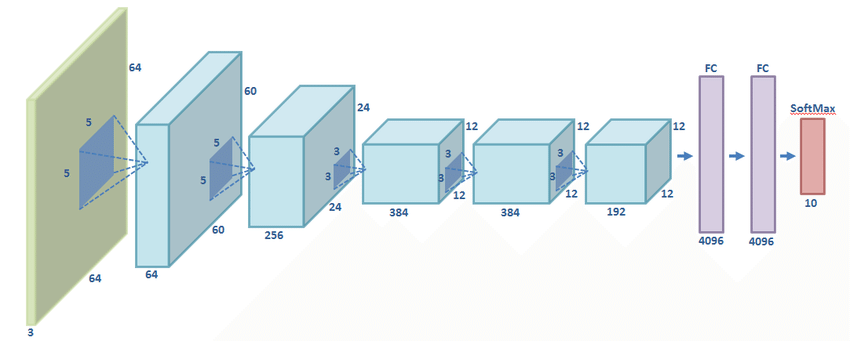

AlexNet：深度网络的开山之作

AlexNet是"深度网络"的首次尝试，也非常的成功，是第一个在大规模图像数据集上取得成功的模型

为了在大规模的数据集上使用，首先肯定需要提高网络的表达能力，因此，要么加深网络，要么扩宽网络，事实上我们在VGG中已经体会到细长网络的优点，因此这里作者也是使用的细长结构，后面的深度卷积神经网络也基本都以此为主。

那么在有了足够的表达能力后（参数量很大），就需要解决网络表达能力提高与此同时带来的问题：

（1）容易梯度爆炸/消失的问题（使用ReLU激活函数）

（2）网络训练慢的问题（首次引入了多GPU加速训练）

（3）解决过拟合问题（数据增强，Dropout）

激活函数——大道至简

AlexNet使用ReLU激活函数替代之前的网络常用的sigmoid或tanh


AlexNet引入了一些对抗过拟合的方法：

（1）使用数据增强方法，包括随机裁剪，水平翻转，随机旋转，亮度调整等，其思想为希望网络提取到的是输入的有效调整，即即便经过了这些变化，特征应该也基本有用，才是好的特征

(例如如果输入的人脸都是水平的，那么不经过数据增强，网络很有可能会认为人脸都是水平的)

特别的：亮度调整，改变RGB通道的强度，使得网络对于光照强度和颜色的不变性

（2）使用dropout方法
即在训练过程中，在隐藏层随机选择一部分的神经元禁用，使得网络在训练中不会过度的依赖某些神经元，引入正则化，减小过拟合的风险

最终经过一系列的卷积操作后，（我认为这部分卷积操作为特征提取功能）再经过全连接层进行分类操作，即可完成图像分类的任务

# model

In [ ]:
"""模型"""

import torch

class AlexNet_mini(torch.nn.Module):
    def __init__(self, num_classes=1000,init_weights=False): # 分类类别数，根据实际任务更改
        super(AlexNet_mini, self).__init__()
        # 使用nn.Sequential模块，直接封装不同地功能块，避免重复定义相同的模块减小工作量，精简代码
        self.feature_extractor = torch.nn.Sequential(
            torch.nn.Conv2d(3,48,11,4,2),
            torch.nn.ReLU(inplace=True), # 参数inplace:
            torch.nn.MaxPool2d(kernel_size=3,stride=2),
            torch.nn.Conv2d(48,128,5,1,2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3,stride=2),
            torch.nn.Conv2d(128, 192, 3,1, 1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(192, 192, 3, 1,1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(192, 128, 3, 1,1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(p=0.5),  # Dropout 随机失活的比例默认也是0.5
            torch.nn.Linear(128 * 6 * 6, 2048),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(2048, 2048),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(2048, num_classes)
        )
        if init_weights: # 是否对模型参数初始化
            self._initialize_weights()
            return

    def _initialize_weights(self):
        """
        参数初始化kaiming_normal，normal_，constant_
        :return:
        """
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, 0, 0.01)
                torch.nn.init.constant_(m.bias, 0)

    def forward(self,x):
        x = self.feature_extractor(x)
        x = torch.flatten(x,start_dim=1) # 对张量扁平化处理，即将X展开
        x = self.classifier(x)
        return x


"""模型"""
class AlexNet(torch.nn.Module):
    def __init__(self, num_classes=1000,init_weights=False): # 分类类别数，根据实际任务更改
        super(AlexNet, self).__init__()
        # 使用nn.Sequential模块，直接封装不同地功能块，避免重复定义相同的模块减小工作量，精简代码
        self.feature_extractor = torch.nn.Sequential(
            torch.nn.Conv2d(3,96,11,4,1),
            torch.nn.ReLU(inplace=True), # 参数inplace:
            torch.nn.MaxPool2d(kernel_size=3,stride=2),
            torch.nn.Conv2d(96,256,5,1,2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3,stride=2),
            torch.nn.Conv2d(256, 384, 3,1, 1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(384, 384, 3, 1,1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(384, 256, 3, 1,1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(256 * 5 * 5, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4096, num_classes)
        )
        if init_weights: # 是否对模型参数初始化
            self._initialize_weights()
            return

    def _initialize_weights(self):
        """
        参数初始化kaiming_normal，normal_，constant_
        :return:
        """
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.Linear):
                torch.nn.init.normal_(m.weight, 0, 0.01)
                torch.nn.init.constant_(m.bias, 0)

    def forward(self,x):
        x = self.feature_extractor(x)
        x = torch.flatten(x,start_dim=1) # 对张量扁平化处理，即将X展开
        x = self.classifier(x)
        return x



# train

In [ ]:
import torch
from torchvision import transforms, datasets
import json
import tqdm
import sys
import os

data_root = '/content/gdrive/MyDrive/Data'
model = 'AlexNet_mini'  # 'AlexNet' AlexNet_mini
mandate = 'hand'  # 'flower' 'hand'
save_path = model + '-' + mandate + '-' + '.pth'
init_weights = True
batch_size = 64
num_epoch = 10
learning_rate = 0.0002


def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    '''数据预处理方法'''
    data_transform = \
        {  # 训练集
            "train": transforms.Compose([transforms.RandomResizedCrop(224),  # 随机裁剪出一个区域,然后resize到224x224大小
                                         transforms.RandomHorizontalFlip(),  # 随机水平翻转
                                         transforms.ToTensor(),  # 图像转换成tensor格式
                                         transforms.Normalize(  # 图像标准化,均值：(0.5,0.5,0.5),标准差：(0.5,0.5,0.5)
                                             (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
            # 测试集
            "val": transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        }

    '''读取数据集'''
    data = mandate + '_data'
    image_path = os.path.join(data_root, data)  # 'D:/data/hand_data' 'D:/data/flower_data'
    # 确认文件路径存在
    assert os.path.exists(image_path), "{} path does not exist.".format(image_path)
    print("working in {} by {}".format(data,model))

    train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"),
                                         transform=data_transform["train"])
    train_num = len(train_dataset)
    validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "val"),
                                            transform=data_transform["val"])
    val_num = len(validate_dataset)
    print("using {} images for training, {} images for validation.".format(train_num, val_num))

    # 确定分类类别
    mandate_list = train_dataset.class_to_idx
    cla_dict = dict((val, key) for key, val in mandate_list.items())
    # write dict into json file
    json_str = json.dumps(cla_dict, indent=4)
    with open('class_indices.json', 'w') as json_file:
        json_file.write(json_str)

    # 多进程 确定合适的worker数量
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    print('Using {} dataloader workers every process'.format(nw))

    '''数据加载器'''
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size, shuffle=True,
                                               num_workers=nw)
    validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                                  batch_size=batch_size, shuffle=False,
                                                  num_workers=nw)

    '''设置网络'''
    num_classes = 6 if mandate == 'hand' else 5
    net = AlexNet(num_classes=num_classes, init_weights=init_weights) if model == 'AlexNet' \
        else AlexNet_mini(num_classes=num_classes, init_weights=init_weights)
    # 将网络发给device
    net.to(device)

    '''训练'''
    loss_function = torch.nn.CrossEntropyLoss()  # 定义损失函数
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  # Adam优化器
    best_acc = 0.0  # 最佳准确率
    for epoch in range(num_epoch):
        running_loss = 0.0
        net.train()  # 将网络设置为训练模式，开启dropout
        train_bar = tqdm.tqdm(train_loader, file=sys.stdout)  # 训练进程进度条显示
        for step, data in enumerate(train_bar):
            images, labels = data

            optimizer.zero_grad()
            outputs = net(images.to(device))
            loss = loss_function(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

            running_loss + loss.item()

            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1, num_epoch, loss)

        '''计算在测试集的准确率'''
        net.eval()  # 在预测时关闭Dropout方法
        acc = 0.0  # 在测试集的准确率 accumulate accurate number / epoch
        with torch.no_grad():
            val_bar = tqdm.tqdm(validate_loader, file=sys.stdout)
            for val_data in val_bar:
                val_images, val_labels = val_data
                outputs = net(val_images.to(device))
                predict_y = torch.max(outputs, dim=1)[1]
                acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

        val_accurate = acc / val_num  # 统计训练过程的平均损失
        print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
              (epoch + 1, running_loss / len(train_loader), val_accurate))

        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)

    print('Finished Training')


if __name__ == "__main__":
    main()


using cuda:0 device.
working in hand_data by AlexNet_mini
using 4548 images for training, 501 images for validation.
Using 2 dataloader workers every process
100%|██████████| 8/8 [01:44<00:00, 13.03s/it]
[epoch 1] train_loss: 0.000  val_accuracy: 0.355
100%|██████████| 8/8 [00:01<00:00,  4.83it/s]
[epoch 2] train_loss: 0.000  val_accuracy: 0.537
100%|██████████| 8/8 [00:01<00:00,  4.68it/s]
[epoch 3] train_loss: 0.000  val_accuracy: 0.533
100%|██████████| 8/8 [00:01<00:00,  4.78it/s]
[epoch 4] train_loss: 0.000  val_accuracy: 0.611
100%|██████████| 8/8 [00:01<00:00,  4.72it/s]
[epoch 5] train_loss: 0.000  val_accuracy: 0.643
100%|██████████| 8/8 [00:02<00:00,  3.02it/s]
[epoch 6] train_loss: 0.000  val_accuracy: 0.848
100%|██████████| 8/8 [00:02<00:00,  3.10it/s]
[epoch 7] train_loss: 0.000  val_accuracy: 0.862
100%|██████████| 8/8 [00:01<00:00,  4.75it/s]
[epoch 8] train_loss: 0.000  val_accuracy: 0.884
100%|██████████| 8/8 [00:01<00:00,  4.82it/s]
[epoch 9] train_loss: 0.000  val_acc

# test

# 特征可视化